In [1]:
import os 
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import sys
sys.path.append("..")

from make_dir import mkdir
from load_yaml import get_yaml

import models.parity_net as solutions
import equations.parity_eqn as equation

from parity_dataset import Sampler
import parity_solver as solver 

import matplotlib.pyplot as plt
import time


In [2]:
# load config
current_path = os.path.abspath(".")
yaml_path = os.path.join(current_path, "parity.yaml")
Config = get_yaml(yaml_path)

# load reference data
absolute_path = os.path.abspath("..")
ref_path = os.path.join(absolute_path, "data/ref_kn1e-3.npz")
ref_rho = torch.Tensor(np.load(ref_path)["macro_frames"][-1]).to('cpu').reshape((-1, 1)) # shape: (100, 1)


In [3]:
time_dimension = Config["physical_config"]["time_dimension"]
space_dimension = Config["physical_config"]["space_dimension"]
velocity_dimension = Config["physical_config"]["velocity_dimension"]
rho_d_in = time_dimension + space_dimension
layers_rho = Config["model_config"]["units_rho"]
rj_d_in = time_dimension + space_dimension + velocity_dimension
layers_r = Config["model_config"]["units_r"]
layers_j = Config["model_config"]["units_j"]

# build neural networks for rho, g
Model_rho = "solutions.Model_rho_" + \
    "{}".format(Config["model_config"]["neural_network_type"])
Model_rho = eval(Model_rho)

model_rho = Model_rho(input_size = rho_d_in, layers = layers_rho, output_size = 1)

Model_r = "solutions.Model_r_" + \
    "{}".format(Config["model_config"]["neural_network_type"])
Model_r = eval(Model_r)

model_r = Model_r(input_size = rj_d_in, layers = layers_r, output_size = 1)

Model_j = "solutions.Model_j_" + \
    "{}".format(Config["model_config"]["neural_network_type"])
Model_j = eval(Model_j)

model_j = Model_j(input_size = rj_d_in, layers = layers_j, output_size = 1)

device_ids = Config["model_config"]["device_ids"]
device = torch.device("cuda:{:d}".format(device_ids[0]) if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    model_rho = nn.DataParallel(model_rho, device_ids = device_ids)    
    model_r = nn.DataParallel(model_r, device_ids = device_ids)
    model_j = nn.DataParallel(model_j, device_ids = device_ids)

    
model_rho.to(device)
model_r.to(device)
model_j.to(device)


DataParallel(
  (module): Model_j_FCNet(
    (_layer_in): Linear(in_features=3, out_features=256, bias=True)
    (_hidden_layers): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (_output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [4]:
# number of paramerters
rho_param_num = sum(neural.numel() for neural in model_rho.parameters())
r_param_num = sum(neural.numel() for neural in model_r.parameters())
j_param_num = sum(neural.numel() for neural in model_j.parameters())
print("Number of paramerters for networks u is: {:6d}, {:6d} and {:6d}. ".format(rho_param_num, r_param_num, j_param_num))


Number of paramerters for networks u is:  50049, 198657 and 198657. 


In [5]:
solutions.Xavier_initi(model_rho)
solutions.Xavier_initi(model_r)
solutions.Xavier_initi(model_j)


In [6]:
# Set optimizer and learning rate decay
optimizer = optim.Adam([
    {'params': model_rho.parameters()},
    {'params': model_r.parameters()},
    {'params': model_j.parameters()},
],  lr=Config["model_config"]["lr"])

scheduler = lr_scheduler.StepLR(
    optimizer, Config["model_config"]["stage_num"], Config["model_config"]["decay_rate"])


In [7]:
Sol = model_rho, model_r, model_j
eqn = equation.Parity(config = Config, sol = Sol)

Iter = Config["model_config"]["iterations"] 
regularizers = Config["model_config"]["regularizers"]

loss_record, error_record = np.array([[]]).T, np.array([[]]*1).T

mkdir(file_dir = "./model_saved")
mkdir(file_dir = "./record")
mkdir(file_dir = "./figure")

time_start = time.time()
print('Begin training.')
print('')
for it in range(Iter):
    
    sampler = Sampler(Config)
    trainloader = [sampler.interior(), sampler.boundary(), sampler.initial()]
        
    risk, error = solver.train_step(sol = Sol,
                                    trainloader = trainloader, 
                                    equation = eqn,  
                                    regularizers = regularizers,
                                    optimizer = optimizer, 
                                    scheduler = scheduler,
                                    ref = ref_rho)
    
    loss = risk["total_loss"]
    res_parity_1_eqn = risk["parity_1"]
    res_parity_2_eqn = risk["parity_2"]
    res_claw_eqn = risk["conservation"]
    res_constraint_eqn = risk["soft_constraint"]
    res_bc_f = risk["bc_f"]
    res_ic_rho = risk["ic_rho"]
    res_ic_f = risk["ic_f"]
    error = error["error"] 

    error = np.array(error, dtype=float).reshape(1, -1)
    loss_record = np.concatenate((loss_record, loss*np.ones((1, 1))), axis=0)
    error_record = np.concatenate((error_record, error), axis=0)

    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    if it % 100 == 0:
    
        print("[Iter: {:6d}/{:6d} - lr: {:.2e} and Loss: {:.2e}]".format(it + 1, Iter, lr, loss))
        print("[Error for density: {:.2e}]".format(float(error[:, 0])))
        print("[Eqn parity_1: {:.2e}, parity_2: {:.2e}, claw: {:.2e}, constraint: {:.2e}]".format(res_parity_1_eqn, res_parity_1_eqn, res_claw_eqn, res_constraint_eqn))
        print("[Boundary: {:.2e}, Initial - rho {:.2e}, f {:.2e}]".format(res_bc_f, res_ic_rho, res_ic_f))

        
    if np.max(error) < 1e-3:
        print("Iteration step: ", it)
        break

np.savez("./record/result.npz",
         loss=loss_record,
         error=error_record[:, 0])

solutions.save_param(model_rho, path = './model_saved/model_rho_params.pkl')
solutions.save_param(model_r, path = './model_saved/model_r_params.pkl')
solutions.save_param(model_j, path = './model_saved/model_j_params.pkl')

print("")
print("Finished training.")
time_end = time.time()
print("Total time is: {:.2e}".format(time_end - time_start), "seconds")


File has already exists!
File has already exists!
File has already exists!
Begin training.

[Iter:      1/ 10000 - lr: 1.00e-03 and Loss: 2.41e+01]
[Error for density: 8.61e-01]
[Eqn parity_1: 9.46e-01, parity_2: 9.46e-01, claw: 9.87e-01, constraint: 9.46e-01]
[Boundary: 1.09e+00, Initial - rho 0.00e+00, f 1.04e+00]
[Iter:    101/ 10000 - lr: 1.00e-03 and Loss: 6.18e-01]
[Error for density: 5.06e-01]
[Eqn parity_1: 1.74e-02, parity_2: 1.74e-02, claw: 3.66e-02, constraint: 1.71e-02]
[Boundary: 1.26e-02, Initial - rho 0.00e+00, f 3.68e-02]
[Iter:    201/ 10000 - lr: 1.00e-03 and Loss: 5.60e-01]
[Error for density: 2.37e-01]
[Eqn parity_1: 1.98e-02, parity_2: 1.98e-02, claw: 2.02e-02, constraint: 1.82e-02]
[Boundary: 6.52e-03, Initial - rho 0.00e+00, f 3.96e-02]
[Iter:    301/ 10000 - lr: 1.00e-03 and Loss: 5.01e-01]
[Error for density: 2.78e-01]
[Eqn parity_1: 1.45e-02, parity_2: 1.45e-02, claw: 2.23e-03, constraint: 1.36e-02]
[Boundary: 6.21e-03, Initial - rho 0.00e+00, f 3.56e-02]
[Ite

In [8]:
# # load model
solutions.load_param(model_rho, './model_saved/model_rho_params.pkl')
solutions.load_param(model_r, './model_saved/model_r_params.pkl')
solutions.load_param(model_j, './model_saved/model_j_params.pkl')

Sol = [model_rho, model_r, model_j]

In [9]:
model_rho, model_r, model_j = Sol

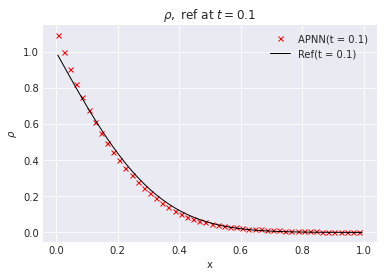

In [11]:
data_size = 100
ref_x = torch.Tensor(np.linspace(0.005, 0.995, data_size).reshape((data_size, 1))).to(device)
ref_t = 0.1 * torch.ones((ref_x.shape[0], 1)).to(device)
approx_rho = eqn.model_rho(model_rho, inputs=[ref_t, ref_x]).cpu().detach().numpy()

plt.style.use("seaborn-dark") 
fig = plt.figure()
plt.plot(ref_x.cpu().detach().numpy() , approx_rho, color = 'r', marker = 'x', linewidth = 0.0, markersize = 5, markevery = 2, label = 'APNN(t = 0.1)')
plt.plot(ref_x.cpu().detach().numpy() , ref_rho, color = 'k', linewidth = 1.0, markersize = 10, label = 'Ref(t = 0.1)')
plt.grid()
plt.legend()
plt.xlabel(r"x")
plt.ylabel(r"$\rho$")
plt.title(r"$\rho,$ ref at $t = 0.1$")
# plt.savefig('./figure/example_parity.pdf')
plt.show()

In [ ]:
# # jupyter notebook to python
# try:   
#     !jupyter nbconvert --to python parity.ipynb
# except:
#     pass